### Movie Generate Prediction

Objective: Predict applicable genres of a movie given its title

In [98]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from tqdm import tqdm
from unidecode import unidecode
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  (accuracy_score, f1_score, precision_score,
    recall_score, confusion_matrix, multilabel_confusion_matrix,
    classification_report, make_scorer, fbeta_score
)
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
tqdm.pandas()

In [2]:
# Unzip .gz files
# !gzip -d title.basics.tsv.gz
# !gzip -d title.akas.tsv.gz

In [3]:
# Read tab-separated files
titles1 = pd.read_csv('title.basics.tsv', sep='\t')
titles2 = pd.read_csv('title.akas.tsv', sep='\t')

/var/folders/y4/vx3h67ld48ld9y909666j4wr0000gp/T/ipykernel_57401/1284639287.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titles1 = pd.read_csv('title.basics.tsv', sep='\t')
/var/folders/y4/vx3h67ld48ld9y909666j4wr0000gp/T/ipykernel_57401/1284639287.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  titles2 = pd.read_csv('title.akas.tsv', sep='\t')


In [4]:
# Download titles datasets from IMDB
# One of the datasets contains the genres and the other contains language information,
# which we'll use to filter
# down to English movies

# !curl https://datasets.imdbws.com/title.basics.tsv.gz --output title.basics.tsv.gz
# !curl https://datasets.imdbws.com/title.akas.tsv.gz --output title.akas.tsv.gz

In [5]:
titles1.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [6]:
titles2.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,5,Карменсита,RU,\N,imdbDisplay,\N,0


In [7]:
# Based on the documentation at https://www.imdb.com/interfaces/ I thought
# title would be in english if language='en', but that's not the case

# Will merge first and investigate/filter once joined
titles2[titles2['language'] == 'en'].head(5)

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
39,tt0000005,4,Blacksmith Scene,CA,en,imdbDisplay,\N,0
97,tt0000010,6,La sortie de l'usine Lumière à Lyon,CA,en,imdbDisplay,\N,0
117,tt0000012,22,The Arrival of a Train,XWW,en,imdbDisplay,\N,0
119,tt0000012,24,L'arrivée d'un train à La Ciotat,CA,en,imdbDisplay,\N,0
122,tt0000012,27,The Arrival of a Train,XEU,en,imdbDisplay,\N,0


In [8]:
# Join titles1 and titles2 to get the language info from titles2 and genre info from titles1
raw = pd.merge(titles1, titles2, how='inner', left_on='tconst', right_on='titleId')
del titles1, titles2

In [9]:
# Looks like 'primaryTitle' is the english title in this case
raw[raw['titleId'] == 'tt0000010'].head(10)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
76,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,10,Вихід робітників із фабрики,UA,\N,imdbDisplay,\N,0
77,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,11,La salida de la fábrica Lumière en Lyon,ES,\N,imdbDisplay,\N,0
78,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,12,Työntekijät poistuvat Lumière-tehtaalta,FI,\N,\N,informal title,0
79,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,13,A munkaidő vége,HU,\N,imdbDisplay,\N,0
80,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,14,Wyjście robotników z fabryki,PL,\N,imdbDisplay,\N,0
81,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,15,Lumière-fabrikens arbetare,FI,sv,\N,informal title,0
82,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,16,Exiting the Factory,US,\N,imdbDisplay,\N,0
83,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,17,La sortie de l'usine Lumière,FR,\N,alternative,\N,0
84,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,18,La sortie de l'usine Lumière à Lyon,\N,\N,original,\N,1
85,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,19,La sortie des usines Lumière,FR,\N,alternative,\N,0


In [10]:
# Further investigation of language/region combinations
raw[raw['language'] == 'en'].head(10) \
    [['primaryTitle', 'originalTitle', 'title', 'language', 'region']]

,primaryTitle,originalTitle,title,language,region
39,Blacksmith Scene,Blacksmith Scene,Blacksmith Scene,en,CA
97,Leaving the Factory,La sortie de l'usine Lumière à Lyon,La sortie de l'usine Lumière à Lyon,en,CA
117,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train,en,XWW
119,The Arrival of a Train,L'arrivée d'un train à La Ciotat,L'arrivée d'un train à La Ciotat,en,CA
122,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train,en,XEU
131,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train at La Ciotat,en,XWW
133,The Photographical Congress Arrives in Lyon,Le débarquement du congrès de photographie à Lyon,The Photographical Congress Arrives in Lyon,en,XWW
179,Boat Leaving the Port,Barque sortant du port,Boat Leaving the Port,en,XWW
213,The Sea,Baignade en mer,A Dip in the Sea,en,XWW
221,The Sea,Baignade en mer,The Sea,en,XWW


In [11]:
# Look at the top 20 regions
raw['region'].value_counts().iloc[:20]

DE     4086446
JP     4084968
FR     4084391
IN     4019931
ES     4007418
IT     3986782
PT     3920908
\N     1872985
US     1391685
GB      431687
CA      212943
XWW     167907
AU      126004
BR      114720
MX       92509
RU       92293
GR       90975
PL       86498
FI       85969
SE       74253
Name: region, dtype: int64

In [12]:
# Look at all entries for one titleId with multiple languages
# Notice that the 'title' column is not always in english, even when
# the language is 'en' 
# i.e. title = 'L'arrivée d'un train à La Ciotat' when language = 'en')
raw[raw['titleId'] == 'tt0000012'] \
        .sort_values(by=['language'], ascending=False) \
        .head(10) \
        [['titleId','primaryTitle', 'originalTitle','title', 'language','region']]

,titleId,primaryTitle,originalTitle,title,language,region
109,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,Bir trenin La Ciotat garına varışı,tr,TR
130,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,Tåget anländer till stationen,sv,FI
120,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,ラ・シオタ駅への列車の到着,ja,JP
131,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train at La Ciotat,en,XWW
119,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,L'arrivée d'un train à La Ciotat,en,CA
122,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train,en,XEU
117,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train,en,XWW
129,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,A Chegada de um Trem à Estação,\N,BR
128,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,Долазак воза на станицу,\N,RS
127,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,Príchod vlaku do stanice La Ciotat,\N,SK


In [13]:
en_regions = ['US', 'GB', 'AUS']

In [14]:
# What about for the regions with a large proportion of english speakers? (US, GB, AUS?)
# Unfortunately most movies in these regions aren't listed as english
raw.query('region in @en_regions')\
    ['language'].value_counts()

\N     1818394
en        4141
es         639
cy          83
yi          63
gd          46
fr           2
hi           1
haw          1
myv          1
cr           1
Name: language, dtype: int64

In [15]:
# Are titles in the XWW region mostly labeled as english? - yes they are!
raw.query('region == "XWW"')['language'].value_counts()

en     165387
\N       1368
es        974
la        109
cmn        48
fr          8
de          3
it          2
ko          2
vi          1
sr          1
zh          1
pt          1
hu          1
ca          1
Name: language, dtype: int64

In [16]:
# Look at titles for the 'XWW' region, which is world-wide release according
# to this forum post:
# https://community-imdb.sprinklr.com/conversations/data-issues-policy-discussions/language-in-titleakastsv/5f4a79f28815453dba91a443

# Looks like this is pretty effective at finding english titles!
raw.query('region == "XWW" and language == "en"') \
    .sample(10) \
    [['titleId','primaryTitle', 'originalTitle','title', 'language','region', 'genres']]

,titleId,primaryTitle,originalTitle,title,language,region,genres
765523,tt0093569,Moors and Christians,Moros y cristianos,Moors and Christians,en,XWW,Comedy
7989335,tt1207645,Sergeant Keroro Super Movie 2: The Deep Sea Pr...,Chougekijouban Keroro Gunsou 2: Shinkai no pur...,Sergeant Keroro Super Movie 2: The Deep Sea Pr...,en,XWW,"Animation,Comedy,Family"
6096365,tt11230720,"The 7.30 Tribute to Paul Lockyer, Gary Ticehur...",The 7.30 Tribute,"The 7.30 Tribute to Paul Lockyer, Gary Ticehur...",en,XWW,"Biography,Documentary,Short"
1501116,tt0275959,Bendito entre las mujeres,Bendito entre las mujeres,Blessed Among Women,en,XWW,"Comedy,Family,Musical"
1185842,tt0171269,A Brother's Revenge,Enteghame baradar,A Brother's Revenge,en,XWW,\N
31112476,tt8193276,Untitled Project,Untitled Project,Untitled Project,en,XWW,"Action,Adventure,Fantasy"
23169764,tt2573868,The Teen Movies Boom,Teen Movies: les origines,The Teen Movies Boom,en,XWW,Documentary
2898349,tt0834923,Back to Kinshasa,Kwenda vutuka Kinshasa,Back to Kinshasa,en,XWW,"Documentary,Short"
16877028,tt1666168,Outside Satan,Hors Satan,Outside Satan,en,XWW,"Crime,Drama,Fantasy"
1540126,tt0288220,Shojo no jakuten,Shojo no jakuten,The Virgin's Weak Point,en,XWW,\N


In [17]:
# Final dataset combinations that appear to be mostly english titles
df_filters = [
    {
        'region': ['XWW'],
        'language': ['en']
    },
    {
        'region' : ['US', 'AUS', 'GB'],
        'language': ['en', r'\N']
    }
]

In [18]:
temp = []
for filter in df_filters:
    temp.append(
        raw.query('region in @filter["region"] and language in @filter["language"]')
    )
df = pd.concat(temp)
del temp

In [19]:
# Looks good after filtering. Using 'title' column as source of truth
df.sample(20)[['titleId', 'title', 'language','region', 'genres']]

,titleId,title,language,region,genres
12117353,tt14031314,Scream: Legacy,\N,US,"Horror,Mystery,Thriller"
27999319,tt6089926,The Cow,\N,US,"Comedy,Short"
21530877,tt2220788,Dancing in the Ashes,\N,GB,"Drama,History,Short"
1588019,tt0304363,The True Story of My Life in Rouen,en,XWW,"Comedy,Drama,Sport"
28218795,tt6259610,Animal Crossing: Wild World,\N,GB,Family
22786036,tt2405806,Chinese Mill Hands Leaving Work,\N,GB,"Documentary,Short"
22561208,tt2377282,Love Speed and Loss,\N,GB,Documentary
4052256,tt1031348,How Did I Get Here,\N,US,"Drama,Sport"
26531476,tt5005546,High Ready,\N,US,"Action,Short"
29963474,tt7465992,Mahanati,\N,US,"Biography,Drama"


In [20]:
# What about titleType column?
df['titleType'].value_counts()

short           582603
movie           575391
tvEpisode       292162
video           214620
tvSeries        156622
tvMovie          73983
tvMiniSeries     28920
tvSpecial        28767
videoGame        28249
tvShort           6605
Name: titleType, dtype: int64

In [21]:
# Show a few examples of each titleType
for titleType in df['titleType'].unique():
    print(f"Sample of {titleType} content")
    print(
        df[df['titleType'] == titleType] \
            .sample(5)
            [['title', 'language','region', 'genres']]
    )
    print('')

Sample of short content
                                    title language region  \
2850899      The Adventures of Salamura 3       en    XWW   
27316251            Erin Murphy Interview       \N     US   
23724148               Peanut Butter Soup       \N     US   
13593946              Out of the Darkness       \N     GB   
27552467  Daddy Issues: A Day in the Park       \N     US   

                            genres  
2850899            Animation,Short  
27316251                     Short  
23724148  Animation,Comedy,Fantasy  
13593946                     Short  
27552467              Comedy,Short  

Sample of movie content
                                  title language region  \
194835          Happiness Is on Its Way       en    XWW   
7196196  Breath: Long Live the Homeland       en    XWW   
120955                Workers, Let's Go       \N     US   
194530                    Lady Gangster       \N     US   
514423    Godzilla vs. the Smog Monster       \N     US   

       

In [22]:
# Let's just keep movie and movie-adjacent content to start
title_types_to_keep = ['movie', 'tvMovie', 'tvMovie', 'tvMiniSeries']
df = df[df['titleType'].isin(title_types_to_keep)]

In [23]:
# Genre analysis - how many are there? What are the most common?
# Genres are stored as a list in each entry, so we'll need to split them out
df['genres_split'] = df['genres'].str.split(pat=',')

In [24]:
# How many titles don't have a genre
num_no_genre = len(df[df['genres'] == r'\N'])
print(f"{num_no_genre} titles don't have a genre")
df = df[df['genres'] != r'\N']
df = df.reset_index(drop=True)

24728 titles don't have a genre


In [25]:
# Split the genres into separate columns
# TODO switch to using multi-label binarizer for faster processing and easier
# reverse transformation
temp = df['genres'].str.get_dummies(sep=',')
genres = list(temp.columns)

In [26]:
temp.head()

,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# Join genres to df
df = pd.concat([df, temp], axis=1)

In [28]:
# If this is 0 then the genres join was successful
df[genres].isna().sum(axis=0).sum()

0

In [29]:
# Set target variable as the genres
y = df[genres]

In [30]:
df['num_genres'] = df[genres].sum(axis=1)

<AxesSubplot: title={'center': 'Number of Genres per Title'}, xlabel='Number of Genres', ylabel='Number of Titles'>

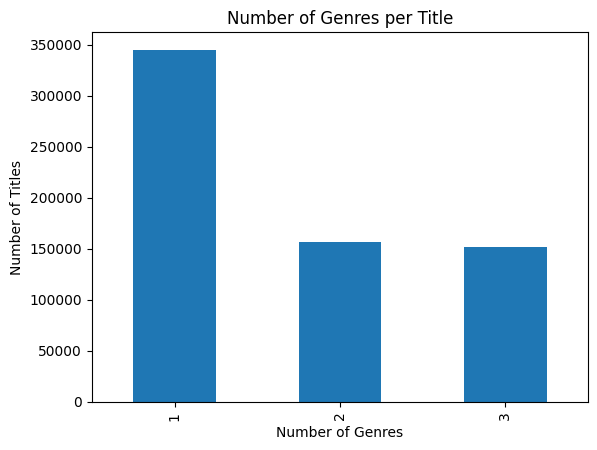

In [31]:
# Most titles have 1 genre, but some have 2 or 3
df['num_genres'].value_counts().plot(
    kind='bar',
    title='Number of Genres per Title',
    xlabel='Number of Genres',
    ylabel='Number of Titles',
)

In [32]:
# Investigate some sample titles - what cleaning is required?
df['title'].sample(20)

10279                         The Maid Seduces the Cowards
422313                               Dialogue Lab: America
417092                                    We Are Not Alone
464809                   Tony Canzoneri vs. Jimmy McLarnin
538093                                         Break Night
554949                                           Emergence
583378                                                 Fat
558256                   Iqbal, a Tale of a Fearless Child
440787                           BBC: The Voice of Britain
583473                       Horizons: Making Lives Better
300745                                                Born
340663                                                Fang
538086                                     The Dark Inside
210620                                   The Fearless Four
432872                                                 Izm
580174                                   Private Screening
630079    Who in the Hell is Lester Barrie? Comedy Speci

In [33]:
# Preprocess / the title text

# Remove numberings (i.e. 1st, 2nd, 3rd, etc.) first so the letters aren't
# stranded after removing the numbers (i.e. 1st -> st, 2nd -> nd)
numbering_re = re.compile(r"(\d+(?:st|nd|rd|th))")

# Keep only alpha characters
alpha_re = re.compile(r"[^a-z]+")

# Remove multiple spaces
multi_space_re = re.compile(r"\s+")

# stop_words = set(stopwords.words('english'))
# Use an abbreviated stopword list to preserve as much contextual information as possible
stop_words = ['for', 'the', 'a', 'an', 'in', 'of', 'as', 'at', 'by', 'for', 'on',
    'and', 'to']

# Don't forget to download wordnet if you haven't already!
# nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Converting to lowercase, keeping only alpha characters, and lemmatizing

    Only removing a select number of stopwords since many stopwords may
    contain useful contextual information for classification
    """
    # Convert unicode to ascii version (to preserve words like Pokémon)
    text = unidecode(text)

    # Lowercase, remove numberings (i.e. 1st, 2nd)
    text = text.lower()
    text = numbering_re.sub(" ", text)

    # Remove apostrophes directly as they cause issues with the tokenizer
    text = text.replace("'", "")

    # Keep only alpha characters
    text = alpha_re.sub(" ", text)

    # Turn multiple spaces into a single space
    text = multi_space_re.sub(" ", text)

    # Tokenize and lemmatize
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Try without removing stop words first since they may be important for classification
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

In [34]:
df['title_cleaned'] = df['title'].progress_apply(clean_text)

100%|██████████| 653566/653566 [00:29<00:00, 21909.88it/s]


In [35]:
df.sample(20)[['title', 'title_cleaned', 'genres']]

,title,title_cleaned,genres
33917,Family Obligations 2,"[family, obligation]",Crime
596380,Aging Trees of Knowledge,"[aging, tree, knowledge]",Documentary
416470,Jazz Fest: A New Orleans Story,"[jazz, fest, new, orleans, story]","Documentary,Music"
583874,Gunpowder,[gunpowder],"Drama,History"
159955,Alfred Hitchcock's Topaz,"[alfred, hitchcock, topaz]","Drama,Thriller"
444799,Art of a Cowboy,"[art, cowboy]",Documentary
162152,The Baby Minder,"[baby, minder]","Horror,Thriller"
416954,Heatseekers,[heatseekers],Action
131864,Courage of Lassie,"[courage, lassie]","Adventure,Drama,Family"
507767,iTrans*,[itrans],Documentary


In [36]:
def dummy_function(text):
    """
    Used to run TfIdf with preapplied tokenization and preprocessing
    """
    return text

In [37]:
# Vectorize the text
vectorizer = TfidfVectorizer(
    tokenizer=dummy_function,
    preprocessor=dummy_function,
    analyzer='word',
    token_pattern=None,
    min_df=3,
)

X = vectorizer.fit_transform(df['title_cleaned'])

In [38]:
# Check our cleaning and tokenization by inspecting most frequent tfidf scores
# Many of the top terms would have been removed had we used a more traditional
# stopword list
tfidf_df = pd.DataFrame(
    {
        'tfidf_score' : np.array(X.sum(axis=0)).T[:,0],
    },
    index=vectorizer.get_feature_names_out().T,
)

tfidf_df.sort_values(by='tfidf_score', ascending=False).head(25)

,tfidf_score
love,5745.040338
my,3783.835086
man,3716.125636
life,3573.566670
girl,3312.658226
night,3309.699735
story,3253.049859
day,3082.138818
woman,2855.988216
i,2835.673623


In [39]:
def query_titles(data=df, query_token=None, column='title_cleaned'):
    """
    Check if a token is in the cleaned title. Used to check token context
    """
    return data[data[column].apply(lambda x: str(query_token).lower() in x)]

## Example function usage
# query_token = 'hook'
# query_titles(query_token=query_token).sample(20)[['title', 'title_cleaned', 'genres']]

In [40]:
def evaluate_model(model_name, y_true, y_pred):
    pass

In [41]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [42]:
X_train = vectorizer.transform(train['title_cleaned'])
X_test = vectorizer.transform(test['title_cleaned'])

# Scale the data (only by variance since the input data is a sparse matrix)
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = train[genres]
y_test = test[genres]

In [81]:
classifiers = [
    {
        'name' : 'Naive Bayes',
        'clf' : OneVsRestClassifier(MultinomialNB(), verbose=1, n_jobs=-1)
    },
    {
        'name' : 'Logistic Regression',
        'clf' : OneVsRestClassifier(LogisticRegression(max_iter=1000),
                                                       verbose=1,
                                                       n_jobs=-1)
    },
    {
        'name' : 'Linear SVC',
        'clf' : OneVsRestClassifier(LinearSVC(max_iter=1000),
                                              verbose=1,
                                              n_jobs=-1)
    },
    {
        'name' : 'K-Nearest Neighbors',
        'clf' : KNeighborsClassifier(n_jobs=-1)
    },
    {
        'name' : 'Random Forest',
        'clf' : RandomForestClassifier(verbose=1, n_jobs=-1)
    },
    {
        'name' : 'Gradient Boosted Trees',
        'clf' : OneVsRestClassifier(GradientBoostingClassifier(),
                                    verbose=1,
                                    n_jobs=-1)
    },
]

In [61]:
# TODO Add cross validation to find best hyperparameters
macro_cols = ['micro avg', 'macro avg', 'weighted avg', 'samples avg']
def eval_model(params):
    clf = params['clf']
    print(f"Training model: {params['name']}")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    macro_results = pd.DataFrame(
            classification_report(y_test,
                                y_pred,
                                target_names=genres,
                                output_dict=True
            )
    )[macro_cols].reset_index(names='metric')

    temp = fbeta_score(y_test, y_pred, beta=2, average='macro')

    # Add f2-score to macro results
    f2_macro = pd.DataFrame(
        {
            "metric" : ["f2-score"],
            "macro avg" : [fbeta_score(y_test, y_pred, beta=2, average='macro', zero_division=0)],
            "micro avg" : [fbeta_score(y_test, y_pred, beta=2, average='micro', zero_division=0)],
            "weighted avg" : [fbeta_score(y_test, y_pred, beta=2, average='weighted', zero_division=0)],
            "samples avg" : [fbeta_score(y_test, y_pred, beta=2, average='samples', zero_division=0)],
        }
    )
    macro_results = pd.concat([macro_results, f2_macro])
    macro_results['model'] = params['name']
    
    per_class_results = pd.DataFrame(
            classification_report(y_test,
                                  y_nb_pred,
                                  target_names=genres,
                                  output_dict=True,
                                  zero_division=0)
        ).drop(columns=macro_cols).T
    
    # Add f2-score to per class results
    f2_scores = fbeta_score(y_test, y_pred, beta=2, average=None)
    per_class_results['f2_score'] = f2_scores

    # save model and results to params dict
    params['clf'] = clf
    params['macro_results'] = macro_results
    params['per_class_results'] = per_class_results
    return macro_results

In [62]:
results_df = []
for classifier in classifiers:
    try:
        eval_model(classifier)
        clf_macro_results = classifier['macro_results']
        results_df.append(clf_macro_results)
    except Exception as e:
        print(f"Error training model: {classifier['name']}")
        print(e)
        continue

if len(results_df) > 1:
    results_df = pd.concat(results_df)
else:
    results_df = results_df[0]

results_df

Training model: Naive Bayes


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    2.7s finished
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,metric,micro avg,macro avg,weighted avg,samples avg,model
0,precision,0.189205,0.135315,0.301824,0.215552,Naive Bayes
1,recall,0.666408,0.622064,0.666408,0.667378,Naive Bayes
2,f1-score,0.294731,0.202366,0.388976,0.303497,Naive Bayes
3,support,222940.000000,222940.000000,222940.000000,222940.000000,Naive Bayes
0,f2-score,0.442964,0.309664,0.494922,0.429277,Naive Bayes


In [63]:
# Random forest is pretty clearly the winner here
results_df.query("metric == 'f2-score'")

,metric,micro avg,macro avg,weighted avg,samples avg,model
2,f1-score,0.294731,0.202366,0.388976,0.303497,Naive Bayes


In [86]:
## TEMP - debugging make_scorer

rf_params = {'n_estimators': 5,
              'max_depth': 10,
              'min_samples_split': 2,
              'min_samples_leaf': 1}

rf_clf = RandomForestClassifier(**rf_params)

rf_clf.fit(X_train, y_train)

scorer = make_scorer(fbeta_score, beta=2, average='weighted')
scorer(rf_clf, X_test, y_test)

0.00014014820696091267

In [108]:
# Find optimal hyperparameters for random forest model and retrain model
# on entire dataset

# Find random forest classifier from params list
# clf_idx = None
# for idx, classifier in enumerate(classifiers):
#     if classifier['name'] == 'Random Forest':
#         clf_idx = idx
# rf_clf = classifiers[clf_idx]['clf']

X = df['title_cleaned']
y = df[genres]

# Recale the data (only by variance since the input data is a sparse matrix)
scaler = StandardScaler(with_mean=False)
# X = scaler.fit_transform(X)

rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
                tokenizer=dummy_function,
                preprocessor=dummy_function,
                analyzer='word',
                token_pattern=None,
                min_df=3,
                )),
    ('scaler', StandardScaler(with_mean=False)),
    ('rf', RandomForestClassifier(n_jobs=-1, verbose=1))
])

# Number of points to sample from the parameter space
n_iter = 15
param_grid = {'rf__n_estimators': [100, 150, 200],
              'rf__max_depth': [20, None],
              'rf__min_samples_split': [1, 2],
              'rf__min_samples_leaf': [1, 2],}

# Use F2 score to weight recall more heavily than precision
# (We don't mind false positives as much as false negatives)

scorer = make_scorer(fbeta_score, beta=2, average='weighted', zero_division=0)

rf_cv = RandomizedSearchCV(rf_pipeline,
                           param_distributions=param_grid,
                           n_iter=n_iter,

                           # Refit on the entire training set with best params
                           refit=True,

                           scoring=scorer,

                           # Use 5-fold cross validation
                           cv=5,
                           verbose=3,
                           n_jobs=-1)

rf_cv.fit(X, y)
print(f"Best model params: {rf_cv.best_params_}")
cv_results_df = pd.DataFrame(rf_cv.cv_results_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent 

[CV 1/5] END rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=5;, score=0.000 total time=  17.9s


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s


[CV 3/5] END rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=5;, score=0.001 total time=  17.7s
[CV 2/5] END rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=5;, score=0.000 total time=  18.2s
[CV 4/5] END rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=5;, score=0.000 total time=  17.8s
[CV 5/5] END rf__max_depth=20, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=5;, score=0.000 total time=  18.4s


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.5s finished
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    1.8s remaining:    3.5s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


[CV 1/5] END rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=6;, score=0.000 total time=  20.0s


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    1.3s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.0s finished
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.7s finished


[CV 2/5] END rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=6;, score=0.000 total time=  22.0s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.8s remaining:    1.6s
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.8s remaining:    1.6s
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    1.2s finished
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    1.3s finished


[CV 3/5] END rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=6;, score=0.000 total time=  23.8s
[CV 4/5] END rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=6;, score=0.000 total time=  23.5s


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    1.0s finished


[CV 5/5] END rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=6;, score=0.000 total time=  23.7s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s finished
[Para

[CV 1/5] END rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=5;, score=0.000 total time=  15.2s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.1s finished


[CV 3/5] END rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=5;, score=0.000 total time=  14.0s
[CV 2/5] END rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=5;, score=0.001 total time=  13.1s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s finished


[CV 4/5] END rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=5;, score=0.000 total time=  13.1s
[CV 5/5] END rf__max_depth=10, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=5;, score=0.000 total time=  12.4s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Best model params: {'rf__n_estimators': 5, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 2, 'rf__max_depth': 20}


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


In [109]:
# Save out pipeline object
with open('rf_pipeline.pkl', 'wb') as f:
    joblib.dump(rf_cv.best_estimator_, f)

In [110]:
# Full prediction pipeline
text = "The Lord of the Ring: The Fellowship of the Ring"
text = clean_text(text)
pred = rf_cv.predict(text)
pred = pd.DataFrame(pred, columns=genres)

# Take only nonzero columns
pred = pred.T[pred.T[0] == 1].index.tolist()
pred

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


[]

In [ ]:
### Example of multi-label classification

# from sklearn.datasets import make_multilabel_classification
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# from sklearn.model_selection import train_test_split

# # Build a synthetic dataset
# X, y = make_multilabel_classification(
#     n_samples=100, n_labels=3, n_features=5, n_classes=4
# )

# y[0:4]